In [ ]:
from google.colab import drive

drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
!pip install spafe joblib

     |████████████████████████████████| 81kB 3.3MB/s 


In [ ]:
#Importing Libraries
import numpy as np
import pandas as pd
import os, sys
import matplotlib.pyplot as plt
import librosa

from spafe.features.lpc import lpc, lpcc
from spafe.features.rplp import rplp, plp

from sklearn.preprocessing import LabelEncoder
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn import metrics

from sklearn import preprocessing

from sklearn.ensemble import RandomForestClassifier
import warnings
import joblib
import seaborn as sns


In [ ]:
def mfcc_feature(audio, sample_rate):
    mfcc = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=40)
 
    return mfcc   # it returns a np.array with size (40,'n') where n is the number of audio frames.

def melspectrogram_feature(audio, sample_rate):
    melspectrogram = librosa.feature.melspectrogram(y=audio, sr=sample_rate, n_fft=2048)
 
    return melspectrogram   # it returns a np.array with size (128,'n') where n is the number of audio frames.

def poly_feature(audio, sample_rate):
    poly_features = librosa.feature.poly_features(y=audio, sr=sample_rate, n_fft=2048)
 
    return poly_features   # it returns a np.array with size (2,'n') where n is the number of audio frames.

def zero_crossing_rate_features(audio):
    zero_crossing_rate = librosa.feature.zero_crossing_rate(y=audio)
 
    return zero_crossing_rate   # it returns a np.array with size (1,'n') where n is the number of audio frames.

def lpcc_feature(audio, sample_rate):
  # compute lpccs
  lifter = 0
  normalize = True
  lpccs = lpcc(sig=audio, fs=sample_rate, num_ceps=13, lifter=lifter, normalize=normalize) 
  return lpccs   # it returns a np.array with size ('n',13) where n is the number of audio frames.

def RPLP_feature(audio, sample_rate):
    num_ceps = 13
    # compute features
    rplps = rplp(audio, sample_rate, num_ceps)
    return rplps  # it returns a np.array with size ('n',13) where n is the number of audio frames.

def pitch_feature(audio, sample_rate):
  pitches, magnitudes = librosa.core.piptrack(audio, sr=16000, fmin=75, fmax=1600)
  return pitches[:200,:] # it returns a np.array with size (200,'n') where n is the number of audio frames.

In [ ]:
def normalize(data):
  data = (data-min(data))/(max(data)-min(data))
  
  return data

In [ ]:
warnings.filterwarnings('ignore')

# setting the path where all file's folder are
root = "gdrive/MyDrive/word_data/kaggle_original_data/train/audio/"

Features_data = pd.DataFrame(columns=['features','class']) 

i = 0
sample_rate = 16000 
no_of_samples = 3000
labels = ['bed', 'cat', 'down', 'left', 'no', 'right', 'seven', 'stop', 'yes', 'up']

# Loading the features in the dataframe
for label in labels:
  
  print(label)
  folders = os.path.join(root,label)
  items = os.listdir(folders)

  for item in items[:no_of_samples]:

    path = os.path.join(folders,item)

    #Convert .wave into array
    samples, sample_rate=librosa.load(path ,sr=sample_rate)

    #Extract Feautures
    MFCC = mfcc_feature(samples , sample_rate)
    MSS = melspectrogram_feature(samples , sample_rate)
    poly = poly_feature(samples , sample_rate)
    ZCR = zero_crossing_rate_features(samples) 

    # flatten an array
    MFCC = MFCC.flatten()
    MSS = MSS.flatten()
    poly = poly.flatten()
    ZCR = ZCR.flatten()

    # normalizing
    # MFCC = normalize(MFCC)

    features = np.concatenate(( MFCC ,MSS, poly, ZCR))

    # padding and trimming
    max_len = 6000

    pad_width = max_len - features.shape[0]
    if pad_width > 0:
      features = np.pad(features, pad_width=((0, pad_width)), mode='constant')

    features = features[:max_len]

    Features_data.loc[i] =[features, label]
    i += 1

bed
cat
down
left
no
right
seven
stop
yes
up


In [ ]:
np.set_printoptions(threshold=sys.maxsize)

In [ ]:
#Saving DataFrame into .CSV

Features_data.to_csv('gdrive/MyDrive/word_data/ML_data_500.csv', index = False)

In [ ]:
Features_data = pd.read_csv('gdrive/MyDrive/word_data/ML_data_500.csv')

In [ ]:
feature=np.array(Features_data['features'].tolist())
target = Features_data.iloc[:,-1]

# converting labels into numeric
le = preprocessing.LabelEncoder()
target=le.fit_transform(target)

# features = preprocessing.MinMaxScaler().fit_transform(features)
feature_train, feature_test, target_train, target_test = train_test_split(feature,target)

In [ ]:
#Create a Gaussian Classifier
clff=RandomForestClassifier(n_estimators=800)

#Train the model using the training sets y_pred=clf.predict(X_test)
clff = clff.fit(feature_train,target_train)

y_predd=clff.predict(feature_test)

# Model Accuracy, how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(target_test, y_predd))

Accuracy: 0.7387114046046761


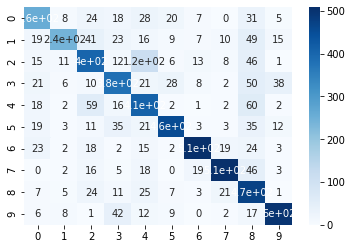

In [ ]:
sns.heatmap(confusion_matrix(target_test,y_predd), annot=True, cmap='Blues')

In [ ]:
model_path = 'gdrive/MyDrive/word_data/'
joblib.dump(clff, model_path+"model_3000.sav")

['gdrive/MyDrive/word_data/model_3000.sav']